# Desafío Kaggle Tarea 1: Predicción de precios de casas



## Descarga de datos de Kaggle

In [1]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c inf-395-tarea-1
!unzip inf-395-tarea-1.zip

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: data_kaggle/imgs/bath_331.jpg  
  inflating: data_kaggle/imgs/bath_333.jpg  
  inflating: data_kaggle/imgs/bath_334.jpg  
  inflating: data_kaggle/imgs/bath_336.jpg  
  inflating: data_kaggle/imgs/bath_339.jpg  
  inflating: data_kaggle/imgs/bath_34.jpg  
  inflating: data_kaggle/imgs/bath_340.jpg  
  inflating: data_kaggle/imgs/bath_341.jpg  
  inflating: data_kaggle/imgs/bath_342.jpg  
  inflating: data_kaggle/imgs/bath_343.jpg  
  inflating: data_kaggle/imgs/bath_346.jpg  
  inflating: data_kaggle/imgs/bath_348.jpg  
  inflating: data_kaggle/imgs/bath_349.jpg  
  inflating: data_kaggle/imgs/bath_350.jpg  
  inflating: data_kaggle/imgs/bath_351.jpg  
  inflating: data_kaggle/imgs/bath_354.jpg  
  inflating: data_kaggle/imgs/bath_355.jpg  
  inflating: data_kaggle/imgs/bath_36.jpg  
  inflating: data_kaggle/imgs/bath_361.jpg  
  inflating: data_kaggle/imgs/bath_362.jpg  
  inflating: data_kaggle/imgs/bath_

## Imports and setup

In [1]:
!pip install -q keras-core
!pip install --upgrade keras-hypetune

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold

from kerashypetune import KerasGridSearch, KerasGridSearchCV


# Aquí se escoge el backend de keras
os.environ["KERAS_BACKEND"] = "tensorflow" # 'torch', 'tensorflow', 'jax'

import keras_core as keras

SEED = 42
keras.utils.set_random_seed(SEED)

Using TensorFlow backend


In [3]:
def viz_imgs(imgs, labels):
  "Función para visualizar imágenes junto a sus labels"
  plt.figure(figsize=(10,10))
  random_inds = np.random.choice(imgs.shape[0],36)
  for i in range(36):
      plt.subplot(6,6,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      image_ind = random_inds[i]
      plt.imshow(np.squeeze(imgs[image_ind]), cmap=plt.cm.binary)
      plt.xlabel(labels[image_ind])
def plot_losses(history, loss):
  "Función para graficar la función de pérdida del modelo"
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Error Graph')
  plt.ylabel(loss.name)
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
def plot_cm(y_pred, y_test):
  "Función para graficar matriz de confusión"
  cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
  cm_display = ConfusionMatrixDisplay(cm).plot()

In [4]:
df_train = pd.read_csv("data_kaggle/data/train_data.csv")
df_test = pd.read_csv("data_kaggle/data/test_data.csv")

## Data Exploration (ejecución opcional)

In [ ]:
df_train.head()

,ID,date,zipcode,lat,long,bedrooms,bathrooms,sqft_living,sqft_lot,floors,...,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,price
0,143,20140515T000000,98003,47.2857,-122.300,3.0,2.25,1590.0,7748.0,2.0,...,0.0,4.0,7.0,1590.0,0.0,1991.0,0.0,1590.0,7606.0,263000.0
1,1175,20141203T000000,98117,47.6885,-122.380,3.0,NaN,2040.0,4005.0,NaN,...,0.0,4.0,8.0,1740.0,300.0,1930.0,0.0,1380.0,4005.0,620000.0
2,221,20140711T000000,98106,47.5150,-122.359,2.0,1.00,640.0,7768.0,1.0,...,0.0,3.0,6.0,640.0,0.0,1942.0,0.0,NaN,7424.0,165000.0
3,1231,20141117T000000,98144,47.5758,-122.309,2.0,1.50,1240.0,NaN,NaN,...,0.0,NaN,8.0,1080.0,160.0,NaN,0.0,1530.0,1209.0,403000.0
4,509,20150402T000000,98038,47.3531,-122.017,3.0,NaN,1990.0,NaN,2.0,...,NaN,3.0,7.0,1990.0,0.0,2010.0,0.0,2580.0,3800.0,318200.0


#### Ejemplos de dataset de imágenes
Hay una foto del baño y una de la cama por cada casa.
Evidentemente, estos son los principales criterios que una persona educada debe considerar a la hora de escoger una residencia.

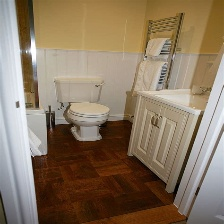

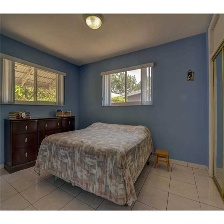

In [ ]:
from IPython.display import Image, display
display(Image(filename='data_kaggle/imgs/bath_100.jpg'))
display(Image(filename='data_kaggle/imgs/bed_100.jpg'))

#### Información del dataset tabular

Hay una cantidad significativa de datos nulos en muchas columnas. Algunas alcanzan un 16% de valores nulos.

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1276 entries, 0 to 1275
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             1276 non-null   int64  
 1   date           1276 non-null   object 
 2   zipcode        1276 non-null   int64  
 3   lat            1276 non-null   float64
 4   long           1276 non-null   float64
 5   bedrooms       1074 non-null   float64
 6   bathrooms      1079 non-null   float64
 7   sqft_living    1082 non-null   float64
 8   sqft_lot       1087 non-null   float64
 9   floors         1084 non-null   float64
 10  waterfront     1076 non-null   float64
 11  view           1082 non-null   float64
 12  condition      1095 non-null   float64
 13  grade          1086 non-null   float64
 14  sqft_above     1089 non-null   float64
 15  sqft_basement  1093 non-null   float64
 16  yr_built       1113 non-null   float64
 17  yr_renovated   1075 non-null   float64
 18  sqft_liv

In [ ]:
df_train.nunique()

ID               1276
date              280
zipcode            66
lat              1000
long              408
bedrooms           10
bathrooms          22
sqft_living       366
sqft_lot          870
floors              5
waterfront          2
view                5
condition           5
grade               8
sqft_above        345
sqft_basement     141
yr_built          114
yr_renovated       32
sqft_living15     307
sqft_lot15        826
price             701
dtype: int64

Ploteamos la matriz de correlación entre features para identificar posibles entradas linealmente dependientes. Las correlaciones más preocupantes son (sqft_above,sqft_living,0.89), (grade,sqft_living,0.81) y (sqft_lot,sqft_lot15,0.81). No hay correlaciones inversas fuertes.

Despues de entrenar el modelo podría ser interesante reentrenar eliminando sqft_above para ver si mejora el rendimiento, pero a priori la correlación no es suficientemente alta para requerirlo.

Además, la característica más fuertemente correlacionada con nuestro target, price, es sqft_living con 0.73.

<ipython-input-9-ff2ac90c0066>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_train.corr(), annot = True)


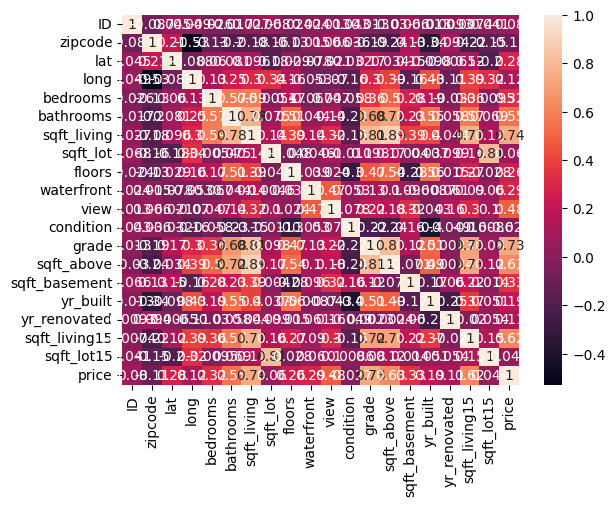

In [ ]:
sns.heatmap(df_train.corr(), annot = True)
plt.rcParams['figure.figsize'] = (35,15)
plt.show()

#### Aqui se podrían usar más gráficos para entender la data.

<Axes: >

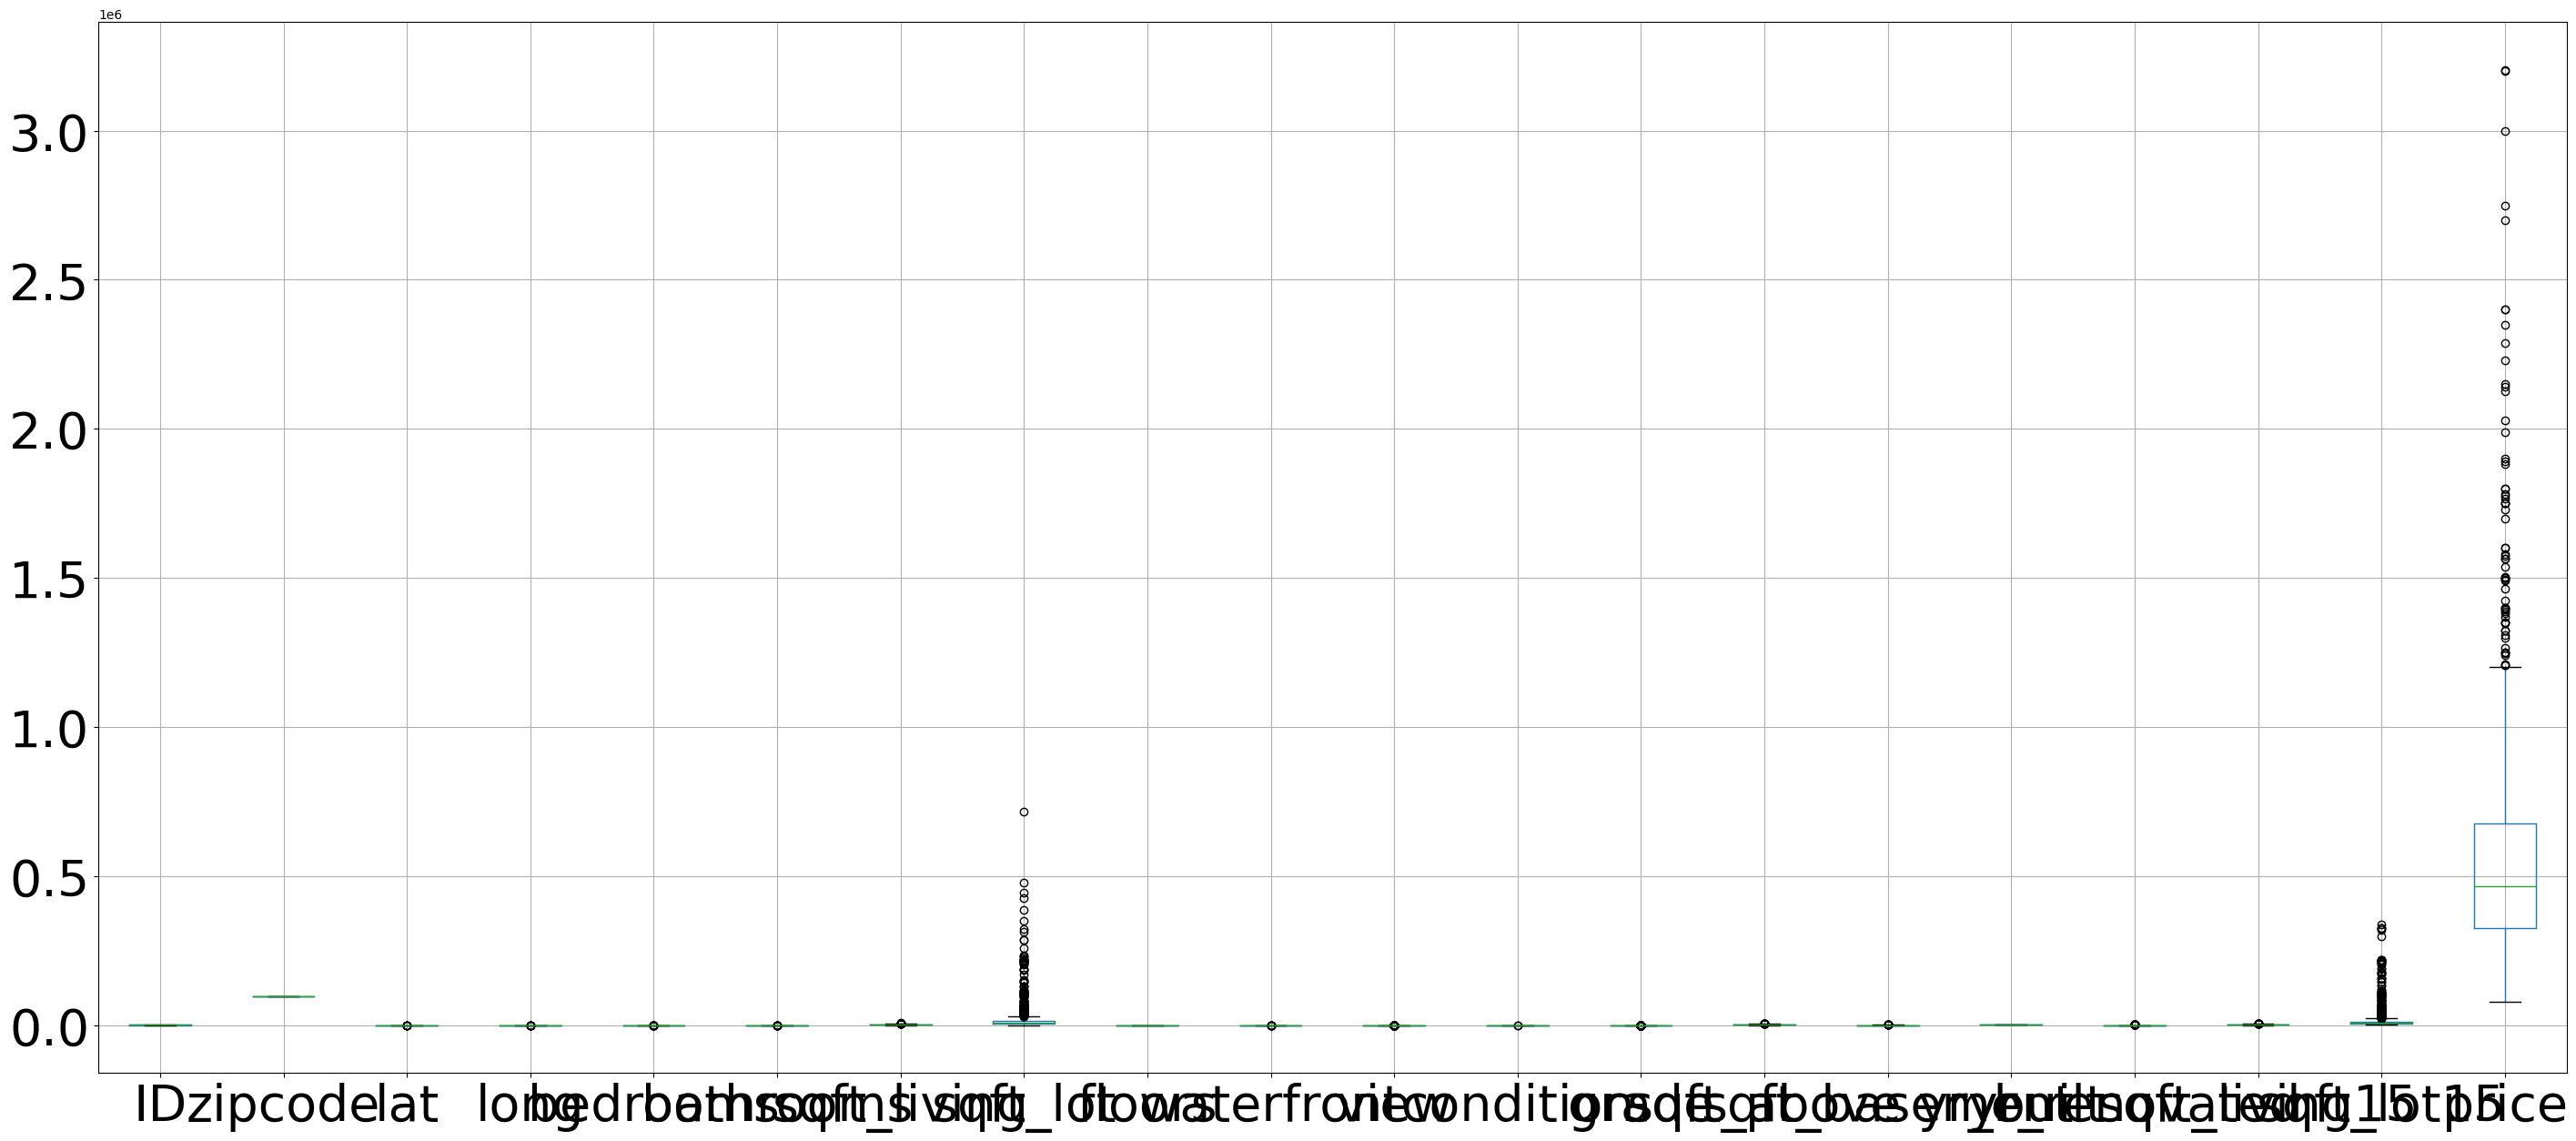

In [ ]:
df_train.boxplot(fontsize=40)

Dado la gráfica de los outlyers de todos las variables, se puede visualizar que existen datos bastante lejanos para algunas variables en específico:
* sqft_lot
* sqft_lot15
* price

Así, visualizaremos estos datos más de cerca

<Axes: >

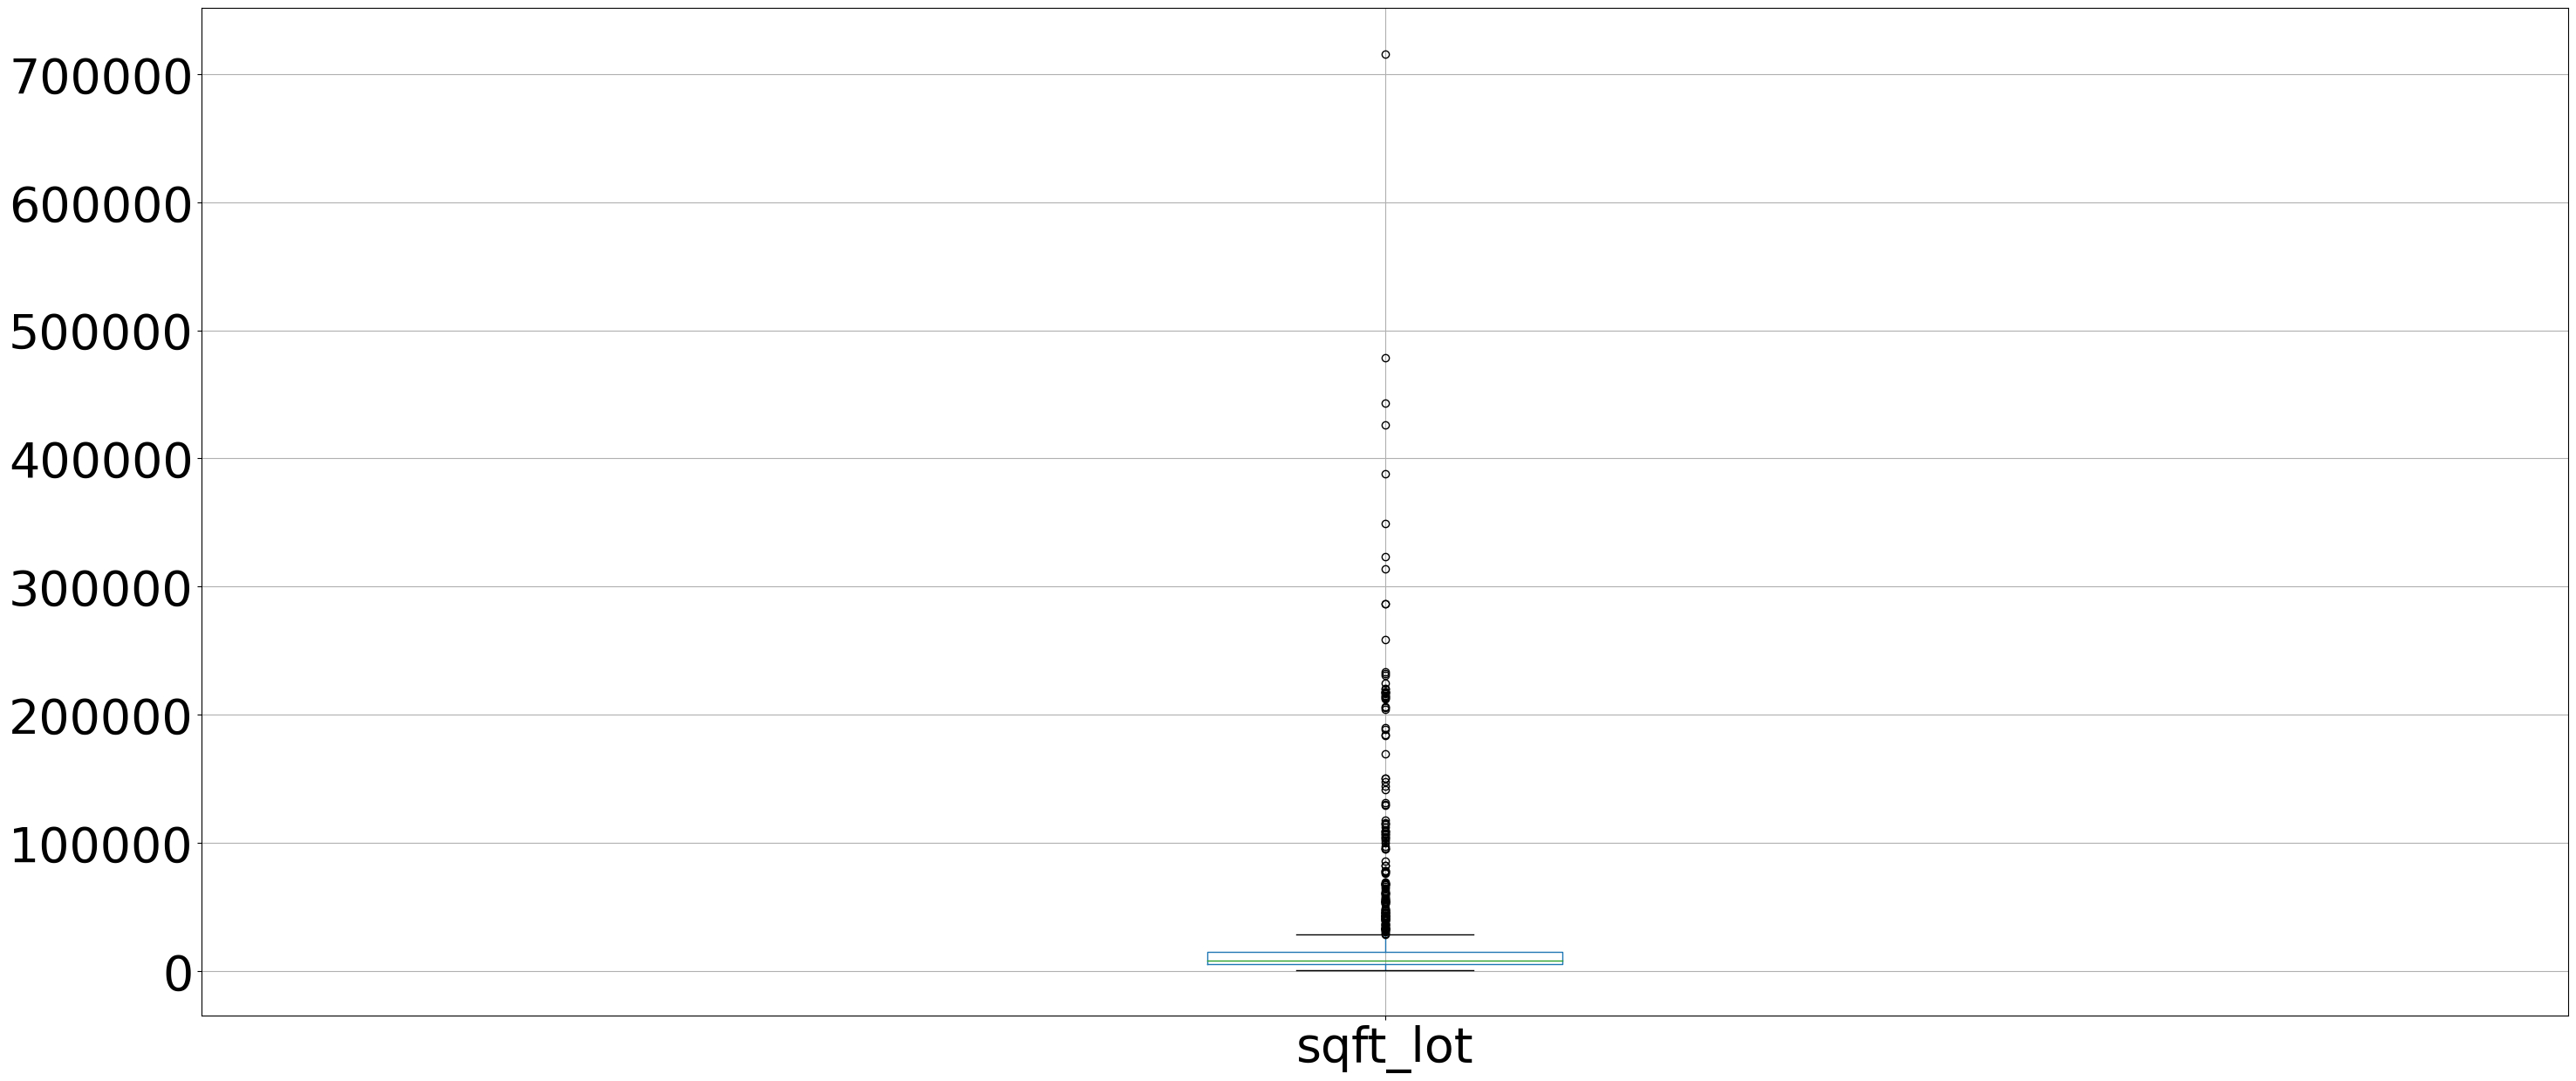

In [ ]:
df_train.boxplot(column=["sqft_lot"], fontsize=40)

<Axes: >

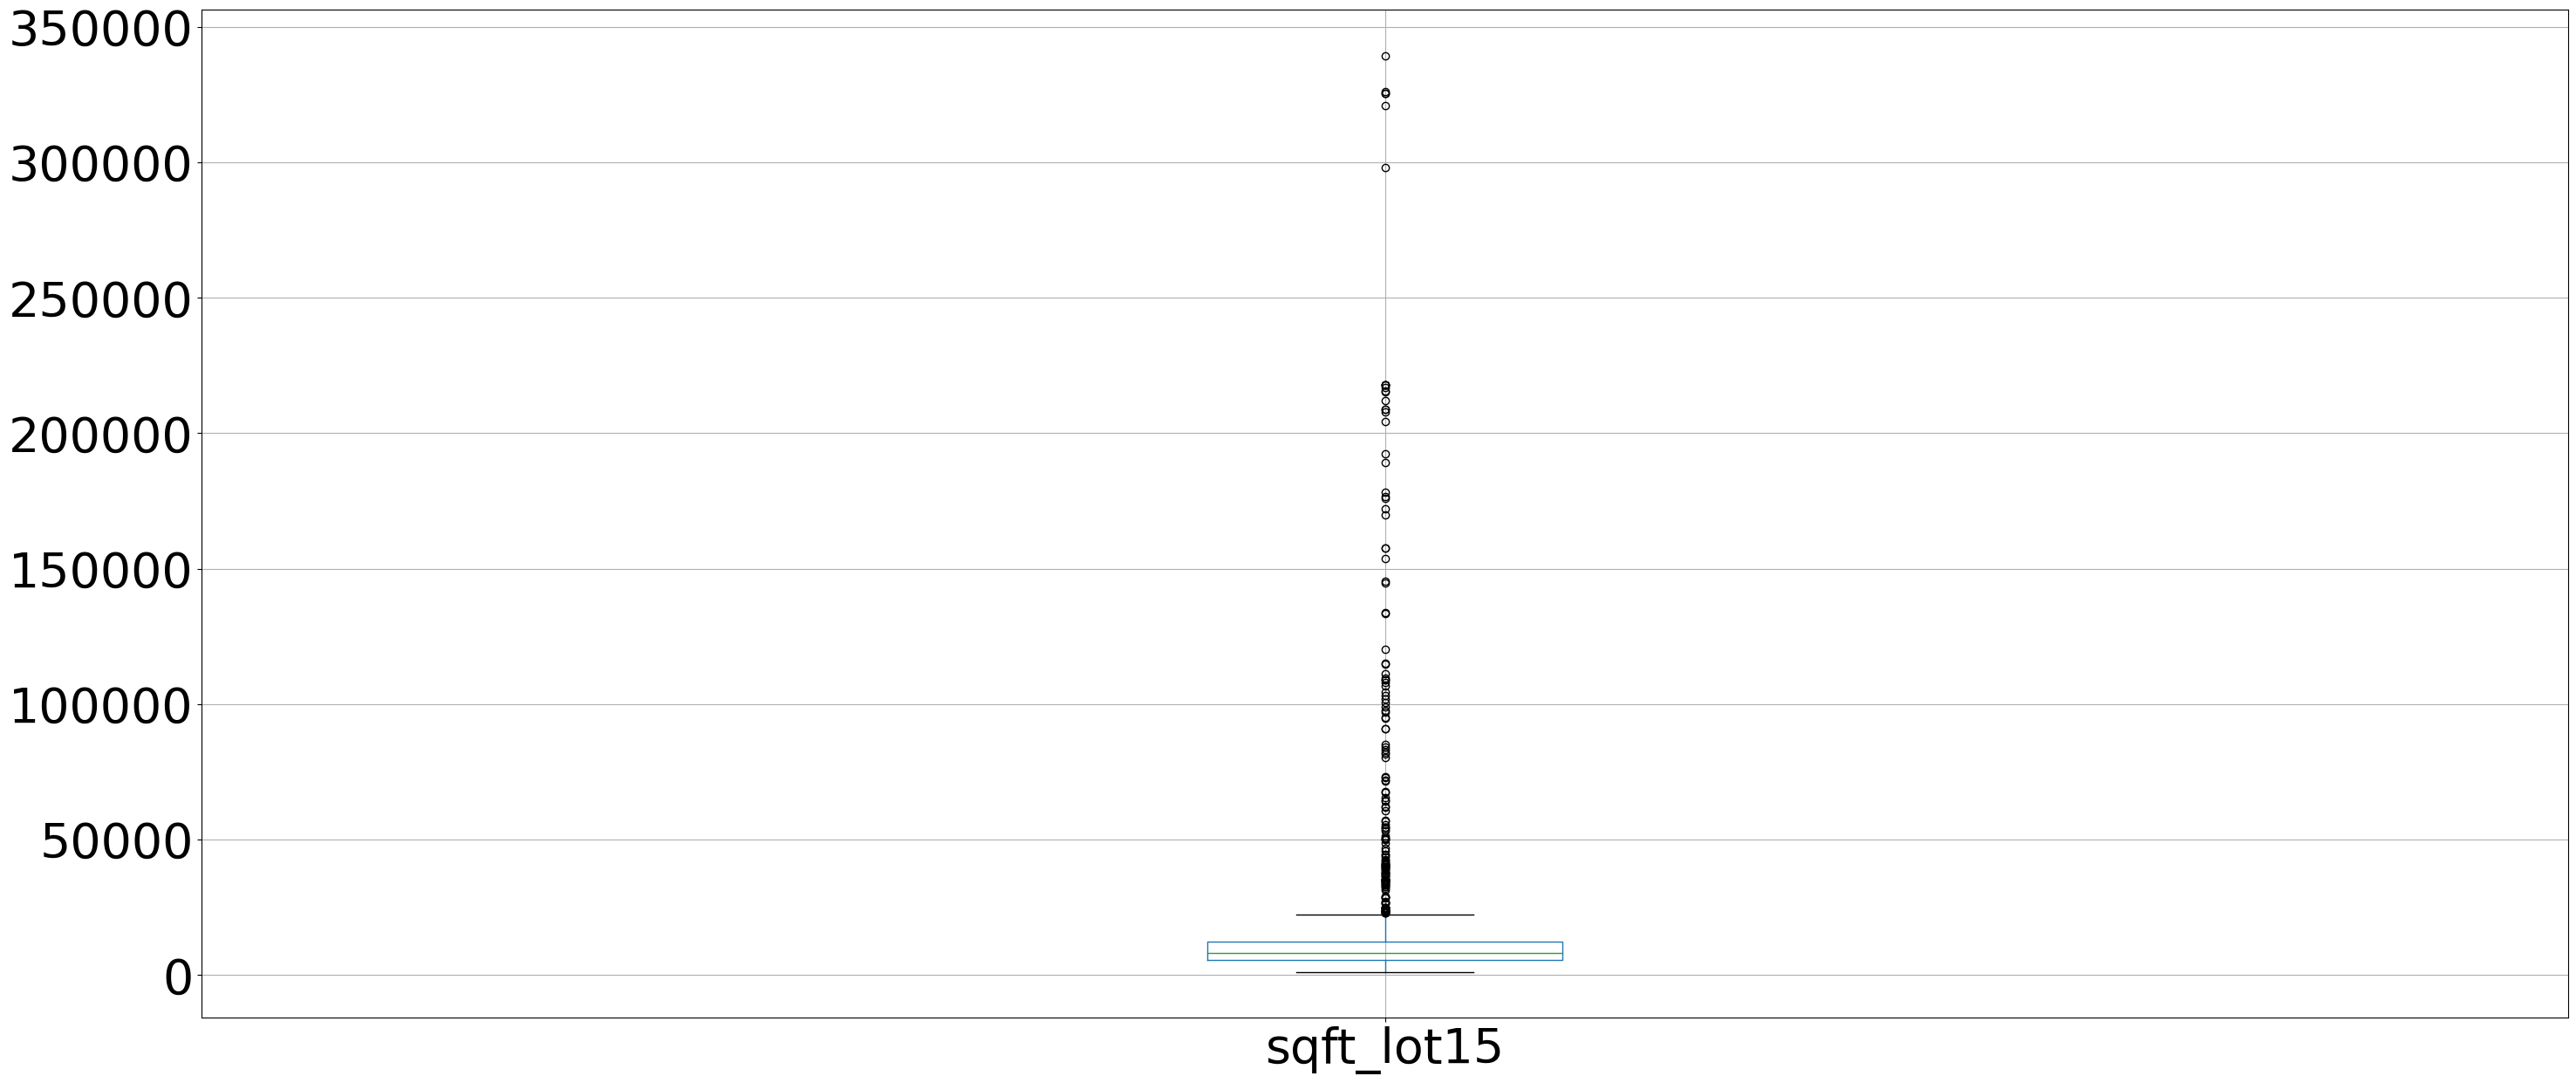

In [ ]:
df_train.boxplot(column=["sqft_lot15"], fontsize=40)

<Axes: >

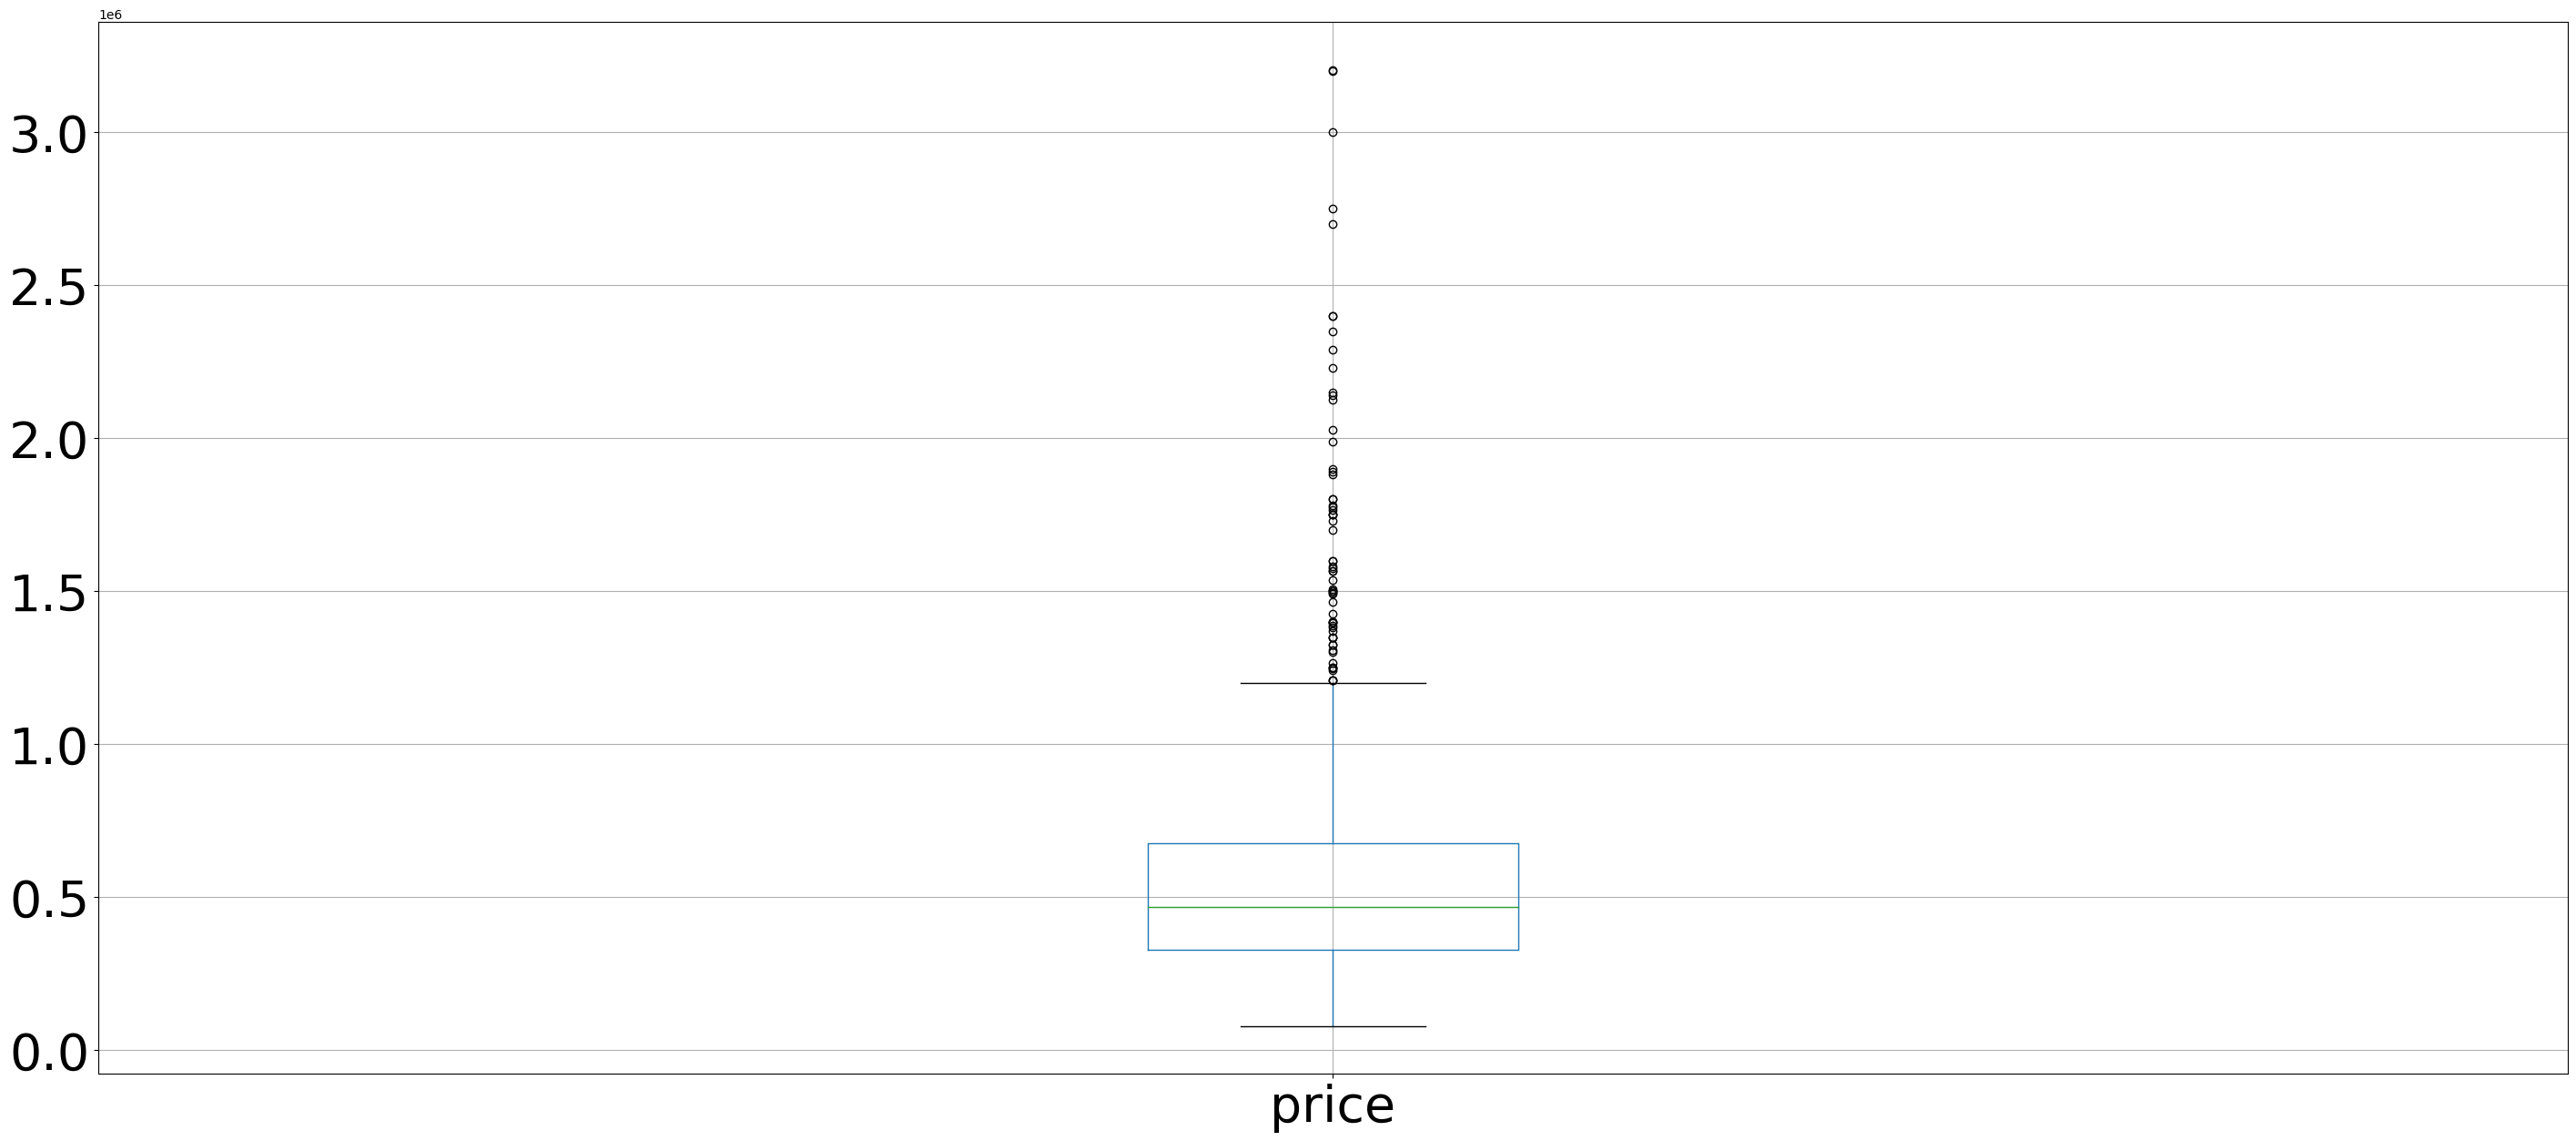

In [ ]:
df_train.boxplot(column=["price"], fontsize=40)

En la columna *sqft_lot* hay 1 dato outlier que puede potencialmente sesgar el modelo que vayamos a crear, ya que es muy diferente de todos. Sería interesante ver un modelo con este dato y otro sin este dato para poder comparar si afecta a la capacidad de predicción.

En la columna *sqft_lot15* hay 5 datos que están mucho más alejados del gran grupo, aunque se puede visualizar que hay un gran número de outlyers en esta columna.

En la columna *price*, los datos outliers están algo más repartidos. Lo que quiere decir que es cuestionable el retirar datos outlyers.

## Feature preprocessing

In [5]:
df_train.head()

,ID,date,zipcode,lat,long,bedrooms,bathrooms,sqft_living,sqft_lot,floors,...,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,price
0,143,20140515T000000,98003,47.2857,-122.300,3.0,2.25,1590.0,7748.0,2.0,...,0.0,4.0,7.0,1590.0,0.0,1991.0,0.0,1590.0,7606.0,263000.0
1,1175,20141203T000000,98117,47.6885,-122.380,3.0,NaN,2040.0,4005.0,NaN,...,0.0,4.0,8.0,1740.0,300.0,1930.0,0.0,1380.0,4005.0,620000.0
2,221,20140711T000000,98106,47.5150,-122.359,2.0,1.00,640.0,7768.0,1.0,...,0.0,3.0,6.0,640.0,0.0,1942.0,0.0,NaN,7424.0,165000.0
3,1231,20141117T000000,98144,47.5758,-122.309,2.0,1.50,1240.0,NaN,NaN,...,0.0,NaN,8.0,1080.0,160.0,NaN,0.0,1530.0,1209.0,403000.0
4,509,20150402T000000,98038,47.3531,-122.017,3.0,NaN,1990.0,NaN,2.0,...,NaN,3.0,7.0,1990.0,0.0,2010.0,0.0,2580.0,3800.0,318200.0


#### Separamos zipcode segun formato utilizado en USA

In [6]:
zipcodes_train = df_train["zipcode"]
zipcodes_test = df_test["zipcode"]


#El primer caracter para todos los zipcodes es igual, por lo que lo ignoramos
df_train["sectional_center"] = [str(z)[1:3] for z in zipcodes_train]
df_train["post_office"] = [str(z)[3:5] for z in zipcodes_train]

df_test["sectional_center"] = [str(z)[1:3] for z in zipcodes_test]
df_test["post_office"] = [int(str(z)[3:5]) for z in zipcodes_test]

#Label encoding para sectional_center, que tiene solo 2 categorias
label_encoder = LabelEncoder()
# Encode labels in column 'species'.
df_train['sectional_center']= label_encoder.fit_transform(df_train['sectional_center'])
df_test['sectional_center']= label_encoder.fit_transform(df_test['sectional_center'])

df_train = df_train.drop(["zipcode"],axis=1)
df_test = df_test.drop(["zipcode"],axis=1)

- Date está en formato ISODate. Podemos obtener tres columnas, año, mes y dia a partir de esto. Luego, podemos utilizar encoding de seno coseno para mantener las relaciones cíclicas de estos datos.
- Podemos eliminar 'ID' pues no aporta en cuanto al entrenamiento del modelo.
- Para inputar los valores NaN utilizaremos K-Nearest-Neighbours de tal manera de obtener una métrica más robusta que solo la media de la columna.

#### Transformación de ISODate a year, month, day

In [7]:
#Primero pasamos de ISODate a year,month,day
df_train["date_year"] = [int(date[0:4]) for date in df_train["date"]]
df_train["date_month"] = [int(date[4:6]) for date in df_train["date"]]
df_train["date_day"] = [int(date[6:8]) for date in df_train["date"]]
df_train = df_train.drop("date",axis=1)

df_test["date_year"] = [int(date[0:4]) for date in df_test["date"]]
df_test["date_month"] = [int(date[4:6]) for date in df_test["date"]]
df_test["date_day"] = [int(date[6:8]) for date in df_test["date"]]
df_test = df_test.drop("date",axis=1)

#### Cyclical feature encoding

In [8]:
#Funcion para pasar columna de df a formato seno coseno
def sinecosine_column(df, column, period):
    df['sin_'+column] = np.sin(2 * np.pi * df[column] / period)
    df['cos_'+column] = np.cos(2 * np.pi * df[column] / period)
    df.drop([column], axis=1, inplace=True)
    return df

#Aceptamos el sesgo de usar 30 días para todos los meses u__u
sinecosine_column(df_train,"date_month",12)
sinecosine_column(df_train,"date_day",30)

sinecosine_column(df_test,"date_month",12)
sinecosine_column(df_test,"date_day",30)

,ID,lat,long,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_renovated,sqft_living15,sqft_lot15,sectional_center,post_office,date_year,sin_date_month,cos_date_month,sin_date_day,cos_date_day
0,1473,47.5544,-122.147,NaN,4.50,4490.0,24767.0,2.0,0.0,2.0,...,0.0,3370.0,32700.0,0,6,2015,8.660254e-01,-5.000000e-01,-9.510565e-01,-0.309017
1,716,47.3573,-122.200,3.0,NaN,1730.0,6007.0,NaN,0.0,0.0,...,0.0,2000.0,6245.0,0,30,2014,-8.660254e-01,5.000000e-01,-2.079117e-01,0.978148
2,1360,47.6085,-122.013,4.0,2.50,3720.0,8633.0,2.0,0.0,0.0,...,NaN,3515.0,9660.0,0,74,2014,-2.449294e-16,1.000000e+00,-4.067366e-01,-0.913545
3,1522,47.4913,-122.081,4.0,2.50,2550.0,NaN,2.0,0.0,0.0,...,0.0,1870.0,56628.0,0,27,2014,-5.000000e-01,-8.660254e-01,5.665539e-16,-1.000000
4,1570,47.4982,-122.362,1.0,0.75,480.0,9750.0,1.0,0.0,0.0,...,0.0,1550.0,9924.0,1,46,2014,-8.660254e-01,-5.000000e-01,-8.660254e-01,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,1475,47.6706,-122.265,3.0,1.00,1710.0,NaN,1.0,0.0,0.0,...,0.0,1610.0,NaN,1,5,2014,-2.449294e-16,1.000000e+00,-9.945219e-01,-0.104528
316,374,47.6622,-121.961,4.0,2.50,2770.0,63118.0,NaN,0.0,0.0,...,0.0,NaN,44224.0,0,14,2014,1.224647e-16,-1.000000e+00,-5.877853e-01,0.809017
317,795,47.7754,-122.032,3.0,NaN,NaN,219978.0,2.0,0.0,0.0,...,0.0,3340.0,217800.0,0,77,2014,-2.449294e-16,1.000000e+00,8.660254e-01,0.500000
318,888,47.4944,-122.165,3.0,1.00,960.0,5512.0,1.0,0.0,0.0,...,0.0,1090.0,5837.0,0,56,2015,1.000000e+00,6.123234e-17,2.079117e-01,0.978148


#### Imputacion de valores usando K-Nearest-Neighbours

In [9]:
from sklearn.impute import KNNImputer

Se utilizo k=2 inicialmente para la cantidad de vecinos. Despues de entrenar el modelo podemos testear otros valores de k como hiperparámetro para ver cual produce mejores resultados.

In [10]:
#Imputacion de train set
imputer = KNNImputer(n_neighbors = 2)

df_train_no_price = df_train.drop("price",axis=1)
df_train_imputed = pd.DataFrame(imputer.fit_transform(df_train_no_price))
df_train_imputed.columns = df_train_no_price.columns
df_train_imputed["price"] = df_train["price"]
df_train = df_train_imputed

#Imputacion de test set
df_test_imputed = pd.DataFrame(imputer.transform(df_test))
df_test_imputed.columns = df_test.columns
df_test = df_test_imputed

In [11]:
train_ids = list(map(int,df_train["ID"]))
df_train = df_train.drop(["ID"], axis=1)
test_ids = list(map(int,df_test["ID"]))
df_test = df_test.drop(["ID"],axis=1)

#### Normalización

In [12]:
scaler = MinMaxScaler((-1,1))
columns_to_scale = list(df_train.columns)
columns_to_NOT_scale = ["price","sin_date_month","cos_date_month","sin_date_day","cos_date_day"]
for c in columns_to_NOT_scale:
  columns_to_scale.remove(c)

prices = df_train["price"]
df_train[columns_to_scale] = pd.DataFrame(columns=columns_to_scale, data=scaler.fit_transform(df_train.drop("price",axis=1)[columns_to_scale]))
df_train["price"] = prices
df_test[columns_to_scale] = pd.DataFrame(columns=columns_to_scale, data=scaler.transform(df_test[columns_to_scale]))

#Escalamos el target de manera separada para luego poder desescalarlo
target_scaler = StandardScaler()
df_train["price"]= target_scaler.fit_transform(np.array(df_train["price"]).reshape(-1,1))


In [13]:
max(df_train["price"])

7.207808474823093

## Red para datos tabulares

In [14]:
y_train = df_train["price"]
X_train = df_train.drop(["price"],axis=1)

In [17]:
input_shape = int(X_train.shape[1])

model = keras.Sequential(
      [
          keras.layers.Input(shape=(input_shape, )),
          keras.layers.Dense(100, activation="tanh"),
          keras.layers.Dense(20, activation="tanh"),
          keras.layers.Dense(1, activation="linear")
      ]
  )

loss = keras.losses.MeanSquaredError()
opt = keras.optimizers.AdamW(learning_rate=0.001)

model.compile(optimizer=opt, loss=loss, metrics=["mean_absolute_error"])

epochs = 255
batch_size = 128
val_split = 0.2
my_callbacks = [
    keras.callbacks.EarlyStopping(
      monitor="val_loss",
      min_delta=0,
      patience=5,
      restore_best_weights=True
    )
]

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=val_split,
                    verbose=1,
                    shuffle=True)


Epoch 1/255
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 1.1049 - mean_absolute_error: 0.7444 - val_loss: 1.0386 - val_mean_absolute_error: 0.5977
Epoch 2/255
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7192 - mean_absolute_error: 0.4859 - val_loss: 0.7743 - val_mean_absolute_error: 0.5691
Epoch 3/255
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5862 - mean_absolute_error: 0.4908 - val_loss: 0.6551 - val_mean_absolute_error: 0.4842
Epoch 4/255
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4885 - mean_absolute_error: 0.3969 - val_loss: 0.5608 - val_mean_absolute_error: 0.4541
Epoch 5/255
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4253 - mean_absolute_error: 0.3786 - val_loss: 0.4965 - val_mean_absolute_error: 0.4305
Epoch 6/255
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3855 - mean_absolute_error: 0.3580 - val_loss: 0.4530 - val_mean_absolute_error: 0.4098
Epoch 7/255
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3564 - mean_absolute_error: 0.3516 - val_loss: 0.425

In [18]:
pred = model.predict(df_test)
pred = np.array([p[0] for p in pred])
rescaled_predictions = target_scaler.inverse_transform(pred.reshape(-1,1))

csv = open("predictions.csv","w")
csv.write("ID,price\n")
for i in range(len(rescaled_predictions)):
  csv.write(str(int(test_ids[i])) + "," + str(rescaled_predictions[i][0]) + "\n")
csv.close()

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step  


## GridSearch para red tabular

In [ ]:
#version GridSearch
#RICKY: copiate este gridsearch a la otra red
#Hay que guardar el entrenamiento con callback pq esta wea no tiene parece
def ANNModel(learning_rate):
  input_shape = int(X_train.shape[1])
  model = keras.Sequential(
      [
          keras.layers.Input(shape=(input_shape, )),
          keras.layers.Dense(100, activation="tanh"),
          keras.layers.Dropout(rate=0.05),
          keras.layers.Dense(50, activation="tanh"),
          keras.layers.Dropout(rate=0.03),
          keras.layers.Dense(25, activation="tanh"),
          keras.layers.Dense(1, activation="relu")
      ]
  )
  loss = keras.losses.MeanSquaredError()
  opt = keras.optimizers.Adam(learning_rate=learning_rate)
  model.compile(optimizer=opt, loss=loss, metrics=["mean_absolute_error"])
  return model

from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

classifier = KerasRegressor(build_fn = ANNModel)
parameters = {'batch_size': [64, 256],
              'epochs': [100],
              'learning_rate': [0.1, 0.001]}
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'neg_mean_absolute_error',
                           cv = 3)
grid_search = grid_search.fit(X_train, y_train, verbose = 3)

In [ ]:
best_parameters = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters: " + str(best_parameters) + str(best_score))

In [ ]:
param_grid = {
    'epochs': 100,
    'batch_size': [16, 64, 128],
    'lr': 1e-3,
    'unit_1': [128,64],
    'unit_2': [64,32],
    'unit_3': [32,16]
}

In [ ]:
def ANNModel(param):
  input_shape = int(X_train.shape[1])
  model = keras.Sequential(
      [
          keras.layers.Input(shape=(input_shape, )),
          keras.layers.Dense(param['unit_1'], activation="tanh"),
          keras.layers.Dropout(rate=0.05),
          keras.layers.Dense(param['unit_2'], activation="tanh"),
          keras.layers.Dropout(rate=0.03),
          keras.layers.Dense(param['unit_3'], activation="tanh"),
          keras.layers.Dense(1, activation="relu")
      ]
  )
  loss = keras.losses.MeanSquaredError()
  opt = keras.optimizers.Adam(learning_rate=param['lr'])
  model.compile(optimizer=opt, loss=loss, metrics=["mean_absolute_error"])
  return model

In [ ]:
cv = KFold(n_splits=3, random_state=33, shuffle=True)
kgs = KerasGridSearchCV(ANNModel, param_grid, cv=cv, monitor='val_loss', greater_is_better=False)

In [ ]:
kgs.search(np.array(X_train), np.array(y_train))

In [ ]:
kgs.folds_best_score

In [ ]:
kgs.folds_best_params

## Preprocesamiento de Imágenes

In [ ]:
from IPython.display import Image, display
from PIL import Image

In [ ]:
#Almacenamos pares id-[fotos]
image_files = os.listdir("data_kaggle/imgs")
images = dict()
for image_file in image_files:
  image_id = image_file.split("_")[1].strip(".jpg")
  if image_id not in images:
    images[image_id] = []
  images[image_id].append(image_file)


(224, 224)


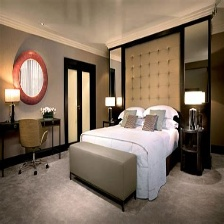

(224, 224)


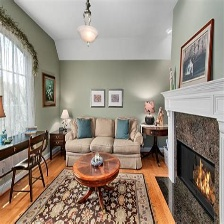

In [ ]:
#Visualizamos las fotos de una id en particular
for file in images["200"]:
  img = Image.open("data_kaggle/imgs/"+file)
  print(img.size)
  display(img)

In [ ]:
#Promediamos las fotos
#Es lo que se nos ocurrió dado que distintas ids tienen distintas cantidades de fotos
#Quiza con esto por lo menos nos quedamos con luminosidad??
for id,files in images.items():
  image_amount = len(files)
  images_array = [np.asarray(Image.open("data_kaggle/imgs/" + file),dtype=np.uint) for file in files]
  average_image = (sum(images_array))//image_amount
  images[id] = average_image.astype(np.uint8)

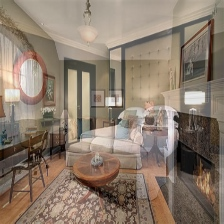

In [ ]:
#Printeamos el promedio de una foto
Image.fromarray(images["200"])

In [ ]:
#El conjunto de entrenamiento serán las fotos promediadas
train_ids_and_prices = df_train[["price"]]
train_ids_and_prices["ID"] = train_ids

dataset = dict()
for index, row in train_ids_and_prices.iterrows():
  id = str(int(row["ID"]))
  if id in images.keys(): #Ojito, algunas IDS tienen precio pero no tienen fotos
    dataset[id] = (images[id], row["price"])
  else:
    dataset[id] = (np.zeros((224,224,3)), row["price"])

<ipython-input-26-6ec920fb0c6d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_ids_and_prices["ID"] = train_ids


In [ ]:
train_ids_and_prices

,price,ID
0,0.059181,143
1,0.173385,1175
2,0.027831,221
3,0.103967,1231
4,0.076839,509
...,...,...
1271,0.134981,954
1272,0.214971,104
1273,0.055022,138
1274,0.742802,1529


In [ ]:
X_train_img = np.array([element[0] for element in dataset.values()])
scaler = MinMaxScaler((0,1))
y_train_img = np.array([y[0] for y in scaler.fit_transform(np.array([element[1] for element in dataset.values()]).reshape(-1,1))])

In [ ]:
X_train_img = X_train_img/255

In [ ]:
X_train_img.shape

(1276, 224, 224, 3)

## Red para imágenes (Promedio)

In [ ]:
#Finalmente se usó el modelo multi input, pero esta es la red que usabamos para la red exclusiva de imagenes

"""
model = keras.Sequential(
    [
        keras.layers.Conv2D(32, (3,3), padding='same', activation='tanh', kernel_initializer="he_normal", input_shape=(224,224,3)),
        keras.layers.MaxPooling2D((2,2)),
        keras.layers.Conv2D(32, (3,3), padding='same', activation='tanh', kernel_initializer="he_normal"),
        keras.layers.MaxPooling2D((2,2)),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(128, activation="tanh"),
        keras.layers.Dense(64, activation="tanh"),
        keras.layers.Dense(1, activation="linear")
    ]
)
"""

loss = keras.losses.MeanSquaredError()
opt = keras.optimizers.AdamW(learning_rate=0.0002)

model.compile(optimizer=opt, loss=loss, metrics=["mean_absolute_error"])

epochs = 100
batch_size = 128
val_split = 0.2
my_callbacks = [
    keras.callbacks.EarlyStopping(
      monitor="val_loss",
      min_delta=0,
      patience=10,
      restore_best_weights=True
    )
]

history = model.fit(X_train_img,
                    y_train_img,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=val_split,
                    callbacks=my_callbacks,
                    verbose=1)

NameError: ignored

## Multiple Input Model

Este modelo termino sin uso, pero fue interesante construirlo de todos modos

In [ ]:
y_train = df_train["price"]
X_train = df_train.drop(["price"],axis=1)

In [ ]:
# primer input
input_images = keras.layers.Input(shape=(224,224,3))
x = keras.layers.Conv2D(32, (3,3), padding='same', activation='tanh', kernel_initializer="he_normal")(input_images)
x = keras.layers.MaxPooling2D((2,2))(x)
x = keras.layers.Conv2D(32, (3,3), padding='same', activation='tanh', kernel_initializer="he_normal")(x)
x = keras.layers.MaxPooling2D((2,2))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Flatten()(x)
dense1 = keras.layers.Dense(5, activation="tanh")(x)


In [ ]:
#segundo input
input_shape = X_train.shape # Entrega (1249, 224, 224, 3)
input_data = keras.layers.Input(shape=(23,))

In [ ]:
merge = keras.layers.concatenate([dense1, input_data])

In [ ]:
x2 = keras.layers.Dense(64, activation="tanh")(merge)
x2 = keras.layers.Dense(64, activation="tanh")(x2)
x2 = keras.layers.Dense(32, activation="tanh")(x2)
output = keras.layers.Dense(1, activation="linear")(x2)

In [ ]:
keras.utils.set_random_seed(234)
model = keras.Model(inputs=[input_images, input_data], outputs=output)

loss = keras.losses.MeanSquaredError()
opt = keras.optimizers.AdamW(learning_rate=0.0005)

model.compile(optimizer=opt, loss=loss, metrics=["mean_absolute_error"])

epochs = 100
batch_size = 128
val_split = 0.2
my_callbacks = [
    keras.callbacks.EarlyStopping(
      monitor="val_loss",
      min_delta=0,
      patience=20,
      restore_best_weights=True
    )
]

history = model.fit([(X_train_img, X_train)],
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=val_split,
                    callbacks=my_callbacks,
                    verbose=1)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - loss: 0.2759 - mean_absolute_error: 0.3936 - val_loss: 0.2223 - val_mean_absolute_error: 0.3905
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 217ms/step - loss: 0.0366 - mean_absolute_error: 0.1442 - val_loss: 0.0254 - val_mean_absolute_error: 0.1265
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 193ms/step - loss: 0.0196 - mean_absolute_error: 0.1103 - val_loss: 0.0192 - val_mean_absolute_error: 0.0952
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 216ms/step - loss: 0.0159 - mean_absolute_error: 0.0901 - val_loss: 0.0194 - val_mean_absolute_error: 0.0938
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 197ms/step - loss: 0.0109 - mean_absolute_error: 0.0728 - val_loss: 0.0195 - val_mean_absolute_error: 0.0935
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 211ms/step - loss: 0.0096 - mean_absolute_error: 0.0668 - val_loss: 0.0199 - val_mean_absolute_error: 0.0947
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - loss: 0.0087 - mean_absolute_error: 0.0640 - val_loss: 

In [ ]:
test_image_files = os.listdir("data_kaggle/imgs")
test_images = dict()
for image_file in test_image_files:
  image_id = image_file.split("_")[1].strip(".jpg")
  if int(image_id) in list(map(int,test_ids)):
    if image_id not in test_images:
      test_images[image_id] = []
    test_images[image_id].append(image_file)

for id,files in test_images.items():
  image_amount = len(files)
  images_array = [np.asarray(Image.open("data_kaggle/imgs/" + file),dtype=np.uint) for file in files]
  average_image = (sum(images_array))//image_amount
  test_images[id] = average_image.astype(np.uint8)

#Rellenamos fotos faltantes
for id in test_ids:
  if str(int(id)) not in test_images.keys():
    test_images[str(int(id))] = np.zeros((224,224,3))

In [ ]:
pred = model.predict([np.array(list(test_images.values())), df_test])
pred = np.array([p[0] for p in pred])
rescaled_predictions = target_scaler.inverse_transform(pred.reshape(-1,1))

csv = open("predictions.csv","w")
csv.write("ID,price\n")
for i in range(len(rescaled_predictions)):
  csv.write(str(int(test_ids[i])) + "," + str(rescaled_predictions[i][0]) + "\n")
csv.close()

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


## Gridsearch para modelo multi input

In [ ]:
param_grid = {
    'epochs': 100,
    'batch_size': [16, 64, 128],
    'lr': 1e-3,
    'act_data': ['elu', 'relu'],
    'unit_1': [128,64],
    'unit_2': [64,32],
    'unit_3': [32,16]
}

In [ ]:
def ANNModel(param):
  input_shape = int(X_train.shape[1])

  input_images = keras.layers.Input(shape=(224,224,3))
  conv1 = keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer="he_normal")(input_images)
  pool1 = keras.layers.MaxPooling2D((2,2))(conv1)
  norm1 = keras.layers.BatchNormalization()(pool1)
  conv2 = keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer="he_normal")(pool1)
  pool2 = keras.layers.MaxPooling2D((2,2))(conv2)
  conv3 = keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer="he_normal")(pool2)
  pool3 = keras.layers.MaxPooling2D((2,2))(conv3)
  norm2 = keras.layers.BatchNormalization()(pool3)
  flat1 = keras.layers.Flatten()(norm2)
  dense1 = keras.layers.Dense(64, activation="tanh")(flat1)

  input_data = keras.layers.Input(shape=(23,))

  merge = keras.layers.concatenate([dense1, input_data])

  hidden1 = keras.layers.Dense(param['unit_1'], activation=param['act_data'])(merge)
  drop1 = keras.layers.Dropout(rate=0.05)(hidden1)
  hidden2 = keras.layers.Dense(param['unit_2'], activation=param['act_data'])(drop1)
  drop2 = keras.layers.Dropout(rate=0.03)(hidden2)
  hidden3 = keras.layers.Dense(param['unit_3'], activation=param['act_data'])(drop2)
  output = keras.layers.Dense(1, activation="relu")(hidden3)

  model = keras.Model(inputs=[input_images, input_data], outputs=output)

  loss = keras.losses.MeanSquaredError()
  opt = keras.optimizers.Adam(learning_rate=param['lr'])
  model.compile(optimizer=opt, loss=loss, metrics=["mean_absolute_error"])
  return model

In [ ]:
es = keras.callbacks.EarlyStopping(
      monitor="val_loss",
      mode="auto",
      patience=10,
      verbose=1,
      min_delta=0.001,
      restore_best_weights=True
    )

hypermodel = ANNModel

kgs = KerasGridSearch(hypermodel, param_grid, monitor='val_loss', greater_is_better=False, tuner_verbose=1)

In [ ]:
cv = KFold(n_splits=3, random_state=33, shuffle=True)

kgs_cv = KerasGridSearch(hypermodel, param_grid, monitor='val_loss', greater_is_better=False, tuner_verbose=1)

In [ ]:
kgs.search([X_train_img, X_train], y_train, validation_split=0.2, callbacks=[es])


48 trials detected for ('epochs', 'batch_size', 'lr', 'act_data', 'unit_1', 'unit_2', 'unit_3')

***** (1/48) *****
Search({'epochs': 100, 'batch_size': 16, 'lr': 0.001, 'act_data': 'relu', 'unit_1': 128, 'unit_2': 64, 'unit_3': 32})
Restoring model weights from the end of the best epoch: 1.
Epoch 11: early stopping
SCORE: 0.04452 at epoch 1

***** (2/48) *****
Search({'epochs': 100, 'batch_size': 16, 'lr': 0.001, 'act_data': 'relu', 'unit_1': 128, 'unit_2': 64, 'unit_3': 16})
Restoring model weights from the end of the best epoch: 6.
Epoch 16: early stopping
SCORE: 0.00723 at epoch 13

***** (3/48) *****
Search({'epochs': 100, 'batch_size': 16, 'lr': 0.001, 'act_data': 'relu', 'unit_1': 128, 'unit_2': 32, 'unit_3': 32})
Restoring model weights from the end of the best epoch: 17.
Epoch 27: early stopping
SCORE: 0.00513 at epoch 26

***** (4/48) *****
Search({'epochs': 100, 'batch_size': 16, 'lr': 0.001, 'act_data': 'relu', 'unit_1': 128, 'unit_2': 32, 'unit_3': 16})
Restoring model we

In [ ]:
kgs.best_params

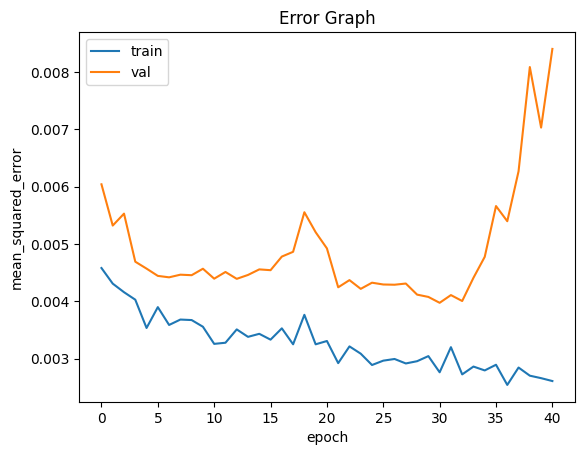

In [ ]:
plot_losses(history, loss)

#### Export model

In [ ]:
test_image_files = os.listdir("data_kaggle/imgs")
test_images = dict()
for image_file in test_image_files:
  image_id = image_file.split("_")[1].strip(".jpg")
  if int(image_id) in list(map(int,test_ids)):
    if image_id not in test_images:
      test_images[image_id] = []
    test_images[image_id].append(image_file)

for id,files in test_images.items():
  image_amount = len(files)
  images_array = [np.asarray(Image.open("data_kaggle/imgs/" + file),dtype=np.uint) for file in files]
  average_image = (sum(images_array))//image_amount
  test_images[id] = average_image.astype(np.uint8)

#Rellenamos fotos faltantes
for id in test_ids:
  if str(int(id)) not in test_images.keys():
    test_images[str(int(id))] = np.zeros((224,224,3))

In [ ]:
test_images["231"].shape

(224, 224, 3)

In [ ]:
#Rellenamos fotos faltantes
for id in test_ids:
  if str(int(id)) not in test_images.keys():
    test_images[str(int(id))] = np.zeros((224,224,3))

In [ ]:
pred = model.predict([np.array(list(test_images.values())), df_test])
pred = np.array([p[0] for p in pred])
rescaled_predictions = y_train_scaler.inverse_transform(pred.reshape(-1,1))

csv = open("predictions.csv","w")
csv.write("ID,price\n")
for i in range(len(rescaled_predictions)):
  csv.write(str(int(test_ids[i])) + "," + str(rescaled_predictions[i][0]) + "\n")
csv.close()

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
